In [1]:
import warnings

# Coisa do Windows

# Ignorar o warning específico do KMeans
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
# Voltar ao normal
# warnings.filterwarnings("default")

# Trabalho Prático 1 de Ciência de Dados

## Imports

In [2]:
!pip install unidecode

In [3]:
import pandas as pd
import nltk
import string
import unidecode
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download("punkt_tab")
nltk.download('stopwords')

[nltk_data] Error loading punkt_tab: Package 'punkt_tab' not found in
[nltk_data]     index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alanz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from numpy import linalg as LA
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_samples, silhouette_score

## Download e leitura

#### Download dos dados

In [5]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg' -O filmes.csv

'wget' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'id' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


#### Leitura dos dados

In [6]:
filmes_df = pd.read_csv("filmes.csv")
filmes_df.head()

,genres,averageRating,numVotes,sinopse,primaryTitle,startYear,runtimeMinutes,actors_names,directors_names
0,Family,7.1,387992,When two kids find and play a magical board ga...,Jumanji,1995,104,['Robin Williams' 'Jonathan Hyde' 'Jonathan Hy...,['Joe Johnston']
1,Romance,6.7,30265,John and Max resolve to save their beloved bai...,Grumpier Old Men,1995,101,['Walter Matthau' 'Jack Lemmon' 'Burgess Mered...,['Howard Deutch']
2,Romance,6.0,12585,"Based on Terry McMillan's novel, this film fol...",Waiting to Exhale,1995,124,['Gregory Hines' 'Dennis Haysbert' 'Mykelti Wi...,['Forest Whitaker']
3,"Romance,Family",6.1,42555,George Banks must deal not only with his daugh...,Father of the Bride Part II,1995,106,['Steve Martin' 'Martin Short' 'George Newbern...,['Charles Shyer']
4,"Crime,Action",8.3,738636,A group of high-end professional thieves start...,Heat,1995,170,['Al Pacino' 'Robert De Niro' 'Val Kilmer' 'Jo...,['Michael Mann']


## Pré-processamento dos dados

#### Convertendo os tokens

Convertendo todos os tokens para letras minúsculas

In [7]:
def tokens_low(tokens):
  return [w.lower() for w in tokens]

Removendo os símbolos de pontuação

In [8]:
table = str.maketrans('', '', string.punctuation)

In [9]:
def tokens_pontuacao(tokens):
  return [w.translate(table) for w in tokens]

Convertendo carcteres especiais

In [10]:
def tokens_char_especical(tokens):
  return [unidecode.unidecode(w).lower() for w in tokens]

#### Filtrando apenas palavras

Extraindo apenas as palavras da lista de tokens

In [11]:
def tokens_apenas_words(tokens):
  return [word for word in tokens if word.isalpha()]

Removendo stop words

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
def tokens_stop_words(tokens):
  return [word for word in tokens if not word in stop_words]

#### Stemming

In [14]:
porter = PorterStemmer()

In [15]:
def tokens_stemming(tokens):
  return [porter.stem(word) for word in tokens]

#### Tokenizer Personalizado

In [16]:
def tokenizer_personalizado(texto):
  tokens = word_tokenize(texto)

  tokens = tokens_low(tokens)
  tokens = tokens_pontuacao(tokens)
  tokens = tokens_char_especical(tokens)
  tokens = tokens_apenas_words(tokens)
  tokens = tokens_stop_words(tokens)
  tokens = tokens_stemming(tokens)

  return tokens

## Configuração do Vectonizer - TF-IDF

In [17]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer_personalizado, max_features=3500, max_df=0.8, ngram_range=(1,3))

## K-means

### Configuração dos Dados

In [18]:
filmes_kmeans_df = filmes_df[['genres', 'sinopse']].copy()
filmes_kmeans_df['genres_list'] = filmes_kmeans_df['genres'].apply(lambda x: x.split(sep=','))
filmes_kmeans_df

,genres,sinopse,genres_list
0,Family,When two kids find and play a magical board ga...,[Family]
1,Romance,John and Max resolve to save their beloved bai...,[Romance]
2,Romance,"Based on Terry McMillan's novel, this film fol...",[Romance]
3,"Romance,Family",George Banks must deal not only with his daugh...,"[Romance, Family]"
4,"Crime,Action",A group of high-end professional thieves start...,"[Crime, Action]"
...,...,...,...
30353,Biography,"""I'll look at you, but not at the camera. It c...",[Biography]
30354,Biography,A musical biography of the great Russian class...,[Biography]
30355,"Crime,Horror",An evil genius uses poison gas to avenge himse...,"[Crime, Horror]"
30356,Romance,A young man narrates his past on how his fathe...,[Romance]


In [19]:
# Filmes com mais de um genero foram multiplicados para que existam apenas um genero por filme
filmes_kmeans_df = filmes_kmeans_df.explode('genres_list')
filmes_kmeans_df

,genres,sinopse,genres_list
0,Family,When two kids find and play a magical board ga...,Family
1,Romance,John and Max resolve to save their beloved bai...,Romance
2,Romance,"Based on Terry McMillan's novel, this film fol...",Romance
3,"Romance,Family",George Banks must deal not only with his daugh...,Romance
3,"Romance,Family",George Banks must deal not only with his daugh...,Family
...,...,...,...
30354,Biography,A musical biography of the great Russian class...,Biography
30355,"Crime,Horror",An evil genius uses poison gas to avenge himse...,Crime
30355,"Crime,Horror",An evil genius uses poison gas to avenge himse...,Horror
30356,Romance,A young man narrates his past on how his fathe...,Romance


### TF-IDF

In [20]:
X = vectorizer.fit_transform(filmes_kmeans_df['sinopse'])

c:\Users\alanz\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
matriz_tf_idf = pd.DataFrame(X.todense(), columns = vectorizer.get_feature_names_out())
matriz_tf_idf

,abandon,abduct,abil,abl,aboard,abroad,abus,academi,accept,access,...,young son,young woman,young women,younger,younger brother,youngest,youngster,youth,zombi,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37557,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37558,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37559,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37560,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dimensionalidade - SVD

In [22]:
svd = make_pipeline(TruncatedSVD(n_components=3500), Normalizer(copy=False))

In [23]:
svd.fit(X)

Pipeline(steps=[('truncatedsvd', TruncatedSVD(n_components=3500)),
                ('normalizer', Normalizer(copy=False))])

#### Curva - Fração Cumulativa da Variância Explicada

Text(0, 0.5, '$f(k)$ - Fração cumulativa da variância explicada')

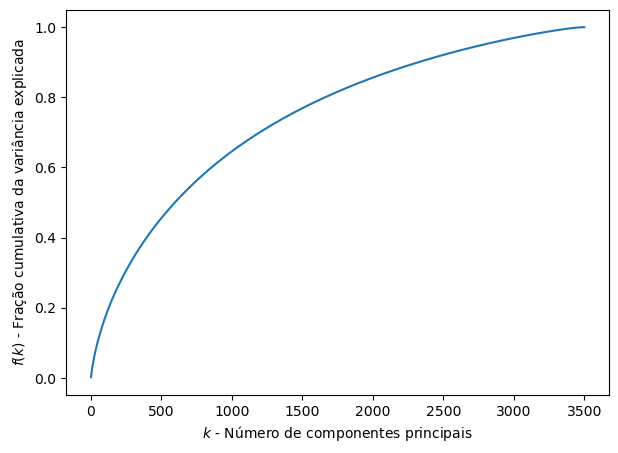

In [24]:
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, svd[0].n_components + 1)], np.cumsum(svd[0].explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada')

### Verificando o K-means - Escolha do K

#### Função Objetivo

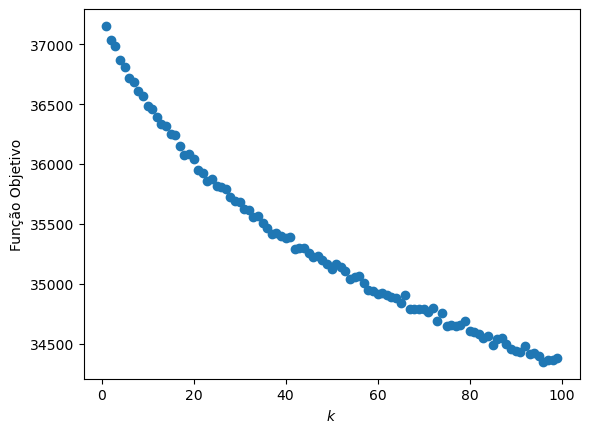

In [25]:
inertia = []
max_groups = 100
for i in range(1, max_groups):
  km = KMeans(n_clusters = i)
  km.fit(X)
  inertia.append(km.inertia_)

plt.scatter(range(1, max_groups), inertia)
_ = plt.ylabel("Função Objetivo")
_ = plt.xlabel(r"$k$")

#### Coeficiente de Silhueta - Quebrado...

TypeError: np.matrix is not supported. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

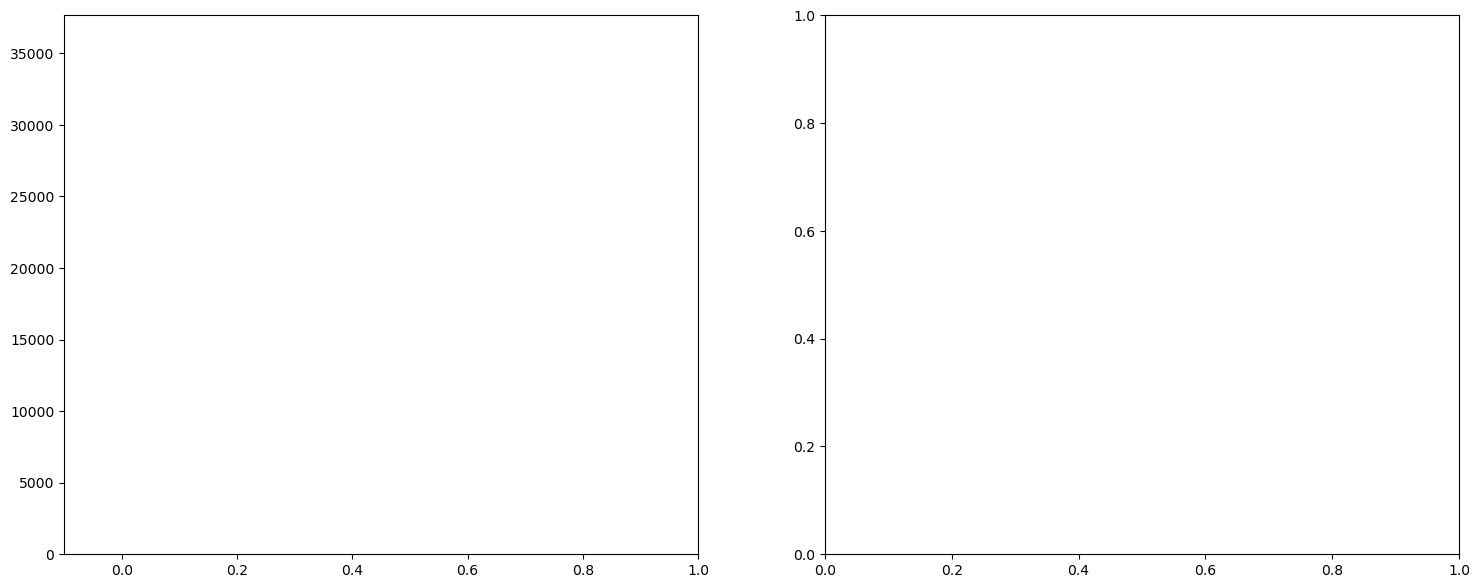

In [32]:
X_DENSE = X.todense()

range_n_clusters = [9, 10, 12, 23, 40]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_DENSE) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_DENSE)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_DENSE, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_DENSE, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_DENSE[:, 0], X_DENSE[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

### Agrupando

In [33]:
k_groups = 23
kmeans = KMeans(n_clusters = k_groups)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

### Análise dos Grupos

#### Atribuindo os Grupos

In [34]:
filmes_kmeans_df['grupos'] = y_kmeans

#### Matriz Generos X Grupos

In [35]:
generosXgrupos = filmes_kmeans_df.groupby(['genres_list', 'grupos']).size().unstack(fill_value=0)
generosXgrupos

grupos,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
genres_list,,,,,,,,,,,,,,,,,,,,,
Action,131,186,184,615,140,225,88,96,2610,40,...,297,504,199,357,181,170,178,69,233,247
Biography,28,54,28,21,50,296,33,28,702,9,...,8,57,4,47,28,1,349,17,27,34
Crime,127,249,137,277,147,317,99,190,2446,162,...,435,504,11,134,233,362,219,83,201,770
Family,262,190,44,68,31,106,22,36,714,0,...,4,186,41,54,79,9,85,49,64,13
Horror,103,311,162,157,175,170,41,44,2203,145,...,50,469,116,147,167,66,92,82,85,413
Musical,20,32,20,24,20,54,89,35,476,0,...,4,81,9,24,55,6,44,13,22,14
Romance,165,357,182,142,346,631,745,202,3191,9,...,30,598,20,163,411,26,406,181,149,92
Sci-Fi,33,56,40,156,37,90,10,20,930,8,...,26,207,355,98,23,17,41,21,23,65
Sport,29,18,13,11,6,54,9,7,265,1,...,1,46,1,19,5,0,54,48,29,4


**Grupos ordenados em ordem decrescente em relação à quantidade de filmes no grupos**

In [36]:
generosXgrupos = generosXgrupos[generosXgrupos.sum().sort_values(ascending=False).index]
generosXgrupos

grupos,8,14,5,22,3,19,1,17,6,11,...,13,21,10,2,15,12,7,18,20,9
genres_list,,,,,,,,,,,,,,,,,,,,,
Action,2610,504,225,247,615,178,186,181,88,405,...,297,233,134,184,199,92,96,170,69,40
Biography,702,57,296,34,21,349,54,28,33,16,...,8,27,6,28,4,113,28,1,17,9
Crime,2446,504,317,770,277,219,249,233,99,328,...,435,201,148,137,11,111,190,362,83,162
Family,714,186,106,13,68,85,190,79,22,34,...,4,64,58,44,41,33,36,9,49,0
Horror,2203,469,170,413,157,92,311,167,41,86,...,50,85,220,162,116,148,44,66,82,145
Musical,476,81,54,14,24,44,32,55,89,19,...,4,22,26,20,9,34,35,6,13,0
Romance,3191,598,631,92,142,406,357,411,745,57,...,30,149,158,182,20,161,202,26,181,9
Sci-Fi,930,207,90,65,156,41,56,23,10,64,...,26,23,64,40,355,21,20,17,21,8
Sport,265,46,54,4,11,54,18,5,9,104,...,1,29,11,13,1,18,7,0,48,1


**Mapa de Calor Geral - Figura 1**

<Axes: xlabel='grupos', ylabel='genres_list'>

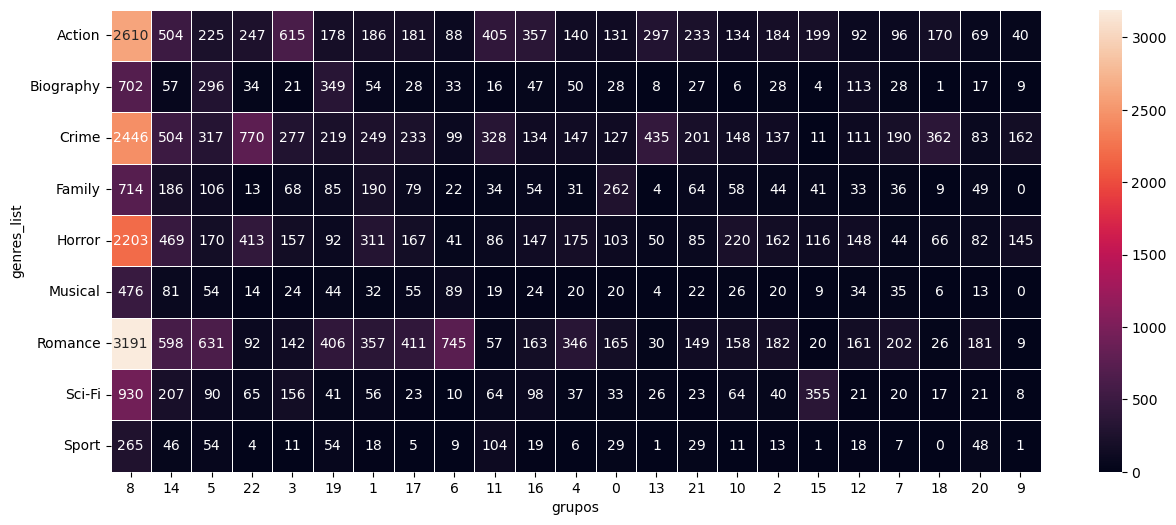

In [37]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generosXgrupos, annot=True, fmt="d", linewidths=0.5, ax=ax)

**Mapa de Calor Colunas Normalizadas - Figura 2**

In [38]:
# Normalizando os valores das colunas
generos_norm = generosXgrupos.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
generos_norm

grupos,8,14,5,22,3,19,1,17,6,11,...,13,21,10,2,15,12,7,18,20,9
genres_list,,,,,,,,,,,,,,,,,,,,,
Action,0.801435,0.829710,0.296360,0.317232,1.000000,0.375342,0.495575,0.433498,0.107337,1.000000,...,0.682028,1.000000,0.598131,1.000000,0.559322,0.517483,0.456410,0.469613,0.333333,0.246914
Biography,0.149351,0.019928,0.419411,0.039164,0.016556,0.843836,0.106195,0.056650,0.032609,0.000000,...,0.016129,0.023697,0.000000,0.087719,0.008475,0.664336,0.107692,0.002762,0.023810,0.055556
Crime,0.745386,0.829710,0.455806,1.000000,0.440397,0.487671,0.681416,0.561576,0.122283,0.802057,...,1.000000,0.848341,0.663551,0.725146,0.028249,0.650350,0.938462,1.000000,0.416667,1.000000
Family,0.153452,0.253623,0.090121,0.011749,0.094371,0.120548,0.507375,0.182266,0.017663,0.046272,...,0.006912,0.199052,0.242991,0.181287,0.112994,0.104895,0.148718,0.024862,0.214286,0.000000
Horror,0.662338,0.766304,0.201040,0.533943,0.241722,0.139726,0.864307,0.399015,0.043478,0.179949,...,0.112903,0.298578,1.000000,0.871345,0.324859,0.909091,0.189744,0.182320,0.410714,0.895062
Musical,0.072112,0.063406,0.000000,0.013055,0.021523,0.008219,0.041298,0.123153,0.108696,0.007712,...,0.006912,0.000000,0.093458,0.040936,0.022599,0.111888,0.143590,0.016575,0.000000,0.000000
Romance,1.000000,1.000000,1.000000,0.114883,0.216887,1.000000,1.000000,1.000000,1.000000,0.105398,...,0.066820,0.601896,0.710280,0.988304,0.053672,1.000000,1.000000,0.071823,1.000000,0.055556
Sci-Fi,0.227273,0.291667,0.062392,0.079634,0.240066,0.000000,0.112094,0.044335,0.001359,0.123393,...,0.057604,0.004739,0.271028,0.157895,1.000000,0.020979,0.066667,0.046961,0.047619,0.049383
Sport,0.000000,0.000000,0.000000,0.000000,0.000000,0.035616,0.000000,0.000000,0.000000,0.226221,...,0.000000,0.033175,0.023364,0.000000,0.000000,0.000000,0.000000,0.000000,0.208333,0.006173


<Axes: xlabel='grupos', ylabel='genres_list'>

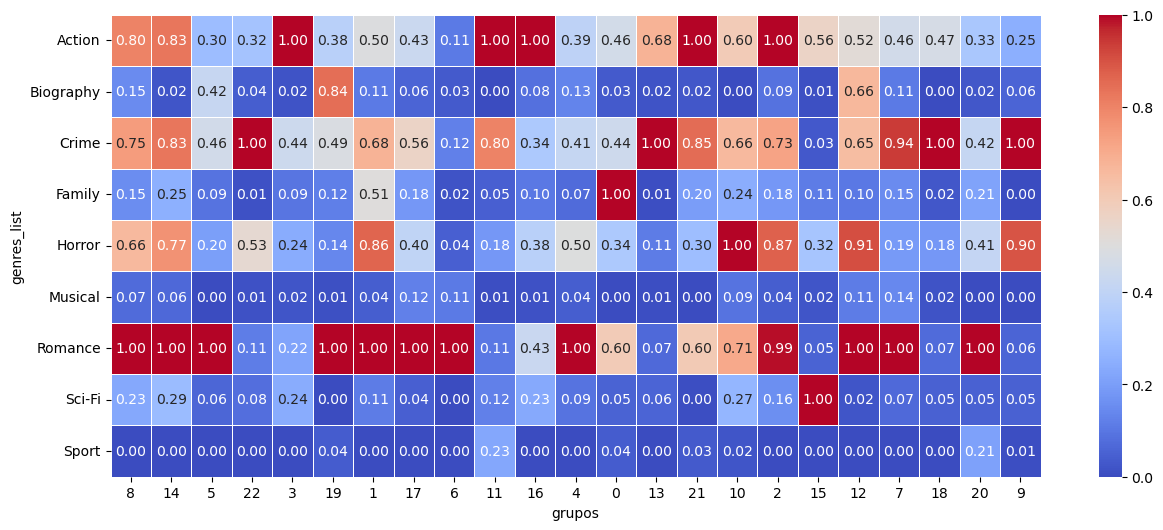

In [39]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generos_norm, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, ax=ax)

**Mapa de Calor Porcentagem de Generos nos Grupos - Figura 3**

In [40]:
generos_por = generosXgrupos.apply(lambda x: x / x.sum())
generos_por

grupos,8,14,5,22,3,19,1,17,6,11,...,13,21,10,2,15,12,7,18,20,9
genres_list,,,,,,,,,,,,,,,,,,,,,
Action,0.192805,0.190045,0.115800,0.149516,0.418083,0.121253,0.128011,0.153130,0.077465,0.363881,...,0.347368,0.279712,0.162424,0.227160,0.263228,0.125855,0.145897,0.258752,0.122558,0.106952
Biography,0.051858,0.021493,0.152342,0.020581,0.014276,0.237738,0.037164,0.023689,0.029049,0.014376,...,0.009357,0.032413,0.007273,0.034568,0.005291,0.154583,0.042553,0.001522,0.030195,0.024064
Crime,0.180690,0.190045,0.163150,0.466102,0.188307,0.149183,0.171370,0.197124,0.087148,0.294699,...,0.508772,0.241297,0.179394,0.169136,0.014550,0.151847,0.288754,0.550989,0.147425,0.433155
Family,0.052744,0.070136,0.054555,0.007869,0.046227,0.057902,0.130764,0.066836,0.019366,0.030548,...,0.004678,0.076831,0.070303,0.054321,0.054233,0.045144,0.054711,0.013699,0.087034,0.000000
Horror,0.162739,0.176848,0.087494,0.250000,0.106730,0.062670,0.214040,0.141286,0.036092,0.077269,...,0.058480,0.102041,0.266667,0.200000,0.153439,0.202462,0.066869,0.100457,0.145648,0.387701
Musical,0.035163,0.030543,0.027792,0.008475,0.016315,0.029973,0.022023,0.046531,0.078345,0.017071,...,0.004678,0.026411,0.031515,0.024691,0.011905,0.046512,0.053191,0.009132,0.023091,0.000000
Romance,0.235724,0.225490,0.324756,0.055690,0.096533,0.276567,0.245699,0.347716,0.655810,0.051213,...,0.035088,0.178872,0.191515,0.224691,0.026455,0.220246,0.306991,0.039574,0.321492,0.024064
Sci-Fi,0.068701,0.078054,0.046320,0.039346,0.106050,0.027929,0.038541,0.019459,0.008803,0.057502,...,0.030409,0.027611,0.077576,0.049383,0.469577,0.028728,0.030395,0.025875,0.037300,0.021390
Sport,0.019576,0.017345,0.027792,0.002421,0.007478,0.036785,0.012388,0.004230,0.007923,0.093441,...,0.001170,0.034814,0.013333,0.016049,0.001323,0.024624,0.010638,0.000000,0.085258,0.002674


<Axes: xlabel='grupos', ylabel='genres_list'>

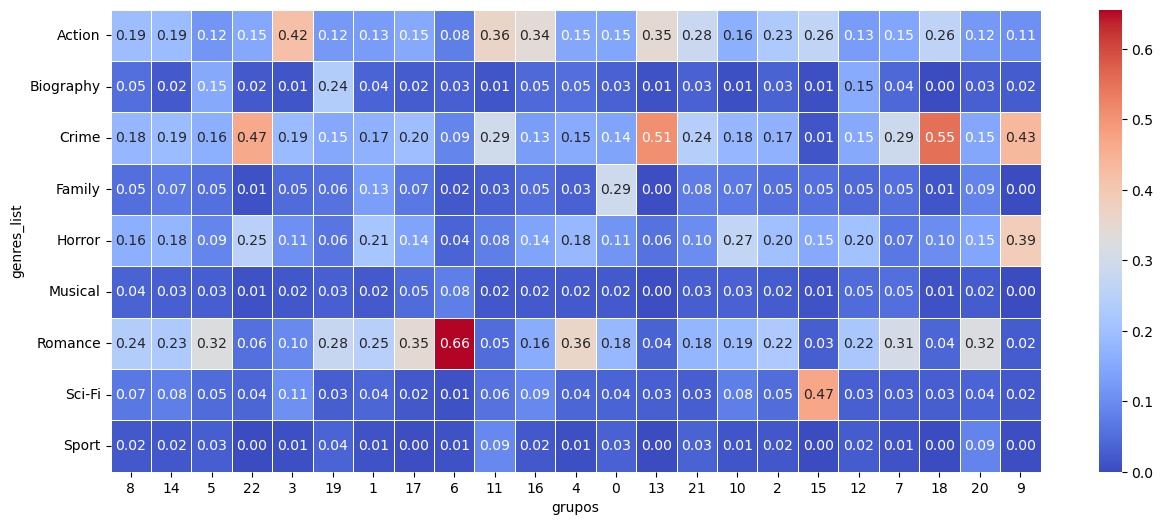

In [41]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generos_por, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, ax=ax)

## Agrupamento Espectral

### Configuração dos Dados

In [42]:
filmes_espec_df = filmes_df[['genres', 'sinopse']].copy()
filmes_espec_df['genres_list'] = filmes_espec_df['genres'].apply(lambda x: x.split(sep=','))
filmes_espec_df

,genres,sinopse,genres_list
0,Family,When two kids find and play a magical board ga...,[Family]
1,Romance,John and Max resolve to save their beloved bai...,[Romance]
2,Romance,"Based on Terry McMillan's novel, this film fol...",[Romance]
3,"Romance,Family",George Banks must deal not only with his daugh...,"[Romance, Family]"
4,"Crime,Action",A group of high-end professional thieves start...,"[Crime, Action]"
...,...,...,...
30353,Biography,"""I'll look at you, but not at the camera. It c...",[Biography]
30354,Biography,A musical biography of the great Russian class...,[Biography]
30355,"Crime,Horror",An evil genius uses poison gas to avenge himse...,"[Crime, Horror]"
30356,Romance,A young man narrates his past on how his fathe...,[Romance]


In [43]:
# Filmes com mais de um genero foram multiplicados para que existam apenas um genero por filme
filmes_espec_df = filmes_espec_df.explode('genres_list')
filmes_espec_df

,genres,sinopse,genres_list
0,Family,When two kids find and play a magical board ga...,Family
1,Romance,John and Max resolve to save their beloved bai...,Romance
2,Romance,"Based on Terry McMillan's novel, this film fol...",Romance
3,"Romance,Family",George Banks must deal not only with his daugh...,Romance
3,"Romance,Family",George Banks must deal not only with his daugh...,Family
...,...,...,...
30354,Biography,A musical biography of the great Russian class...,Biography
30355,"Crime,Horror",An evil genius uses poison gas to avenge himse...,Crime
30355,"Crime,Horror",An evil genius uses poison gas to avenge himse...,Horror
30356,Romance,A young man narrates his past on how his fathe...,Romance


**Amostra Aleatória - 10000**

In [44]:
# Amostra aleatória
filmes_espec_df = filmes_espec_df.sample(n=10000)
filmes_espec_df

,genres,sinopse,genres_list
7019,Crime,Frankie is sent from London to Spain to make a...,Crime
16771,Family,A quirky rom-com where Kush finds the ideal In...,Family
10798,Romance,Carla Campbell receives maintenance payment fr...,Romance
6924,Crime,Ranch foreman Pete Perkins looks to fulfill th...,Crime
16830,Crime,"Sloane, a manipulative lodger, joins Kath's ho...",Crime
...,...,...,...
10552,"Sci-Fi,Horror",A mad scientist transforms himself into an aqu...,Horror
27405,Sci-Fi,"A detective investigates a murder, only to fin...",Sci-Fi
6601,"Sport,Crime",Prison inmates form a football team to challen...,Crime
12167,Horror,"In the early 1600s, Countess Elizabeth Bathory...",Horror


### TF-IDF

In [45]:
X = vectorizer.fit_transform(filmes_espec_df['sinopse'])

c:\Users\alanz\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [46]:
matriz_tf_idf = pd.DataFrame(X.todense(), columns = vectorizer.get_feature_names_out())
matriz_tf_idf

,abandon,abduct,abil,abl,aboard,abroad,abus,academi,accept,accid,...,young women,younger,younger brother,younger sister,yousseff,youth,yu,zombi,zombi apocalyps,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.180518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dimensionalidade - SVD

In [47]:
svd = make_pipeline(TruncatedSVD(n_components=3000), Normalizer(copy=False))

In [48]:
svd.fit(X)

Pipeline(steps=[('truncatedsvd', TruncatedSVD(n_components=3000)),
                ('normalizer', Normalizer(copy=False))])

#### Curva - Fração Cumulativa da Variância Explicada

Text(0, 0.5, '$f(k)$ - Fração cumulativa da variância explicada')

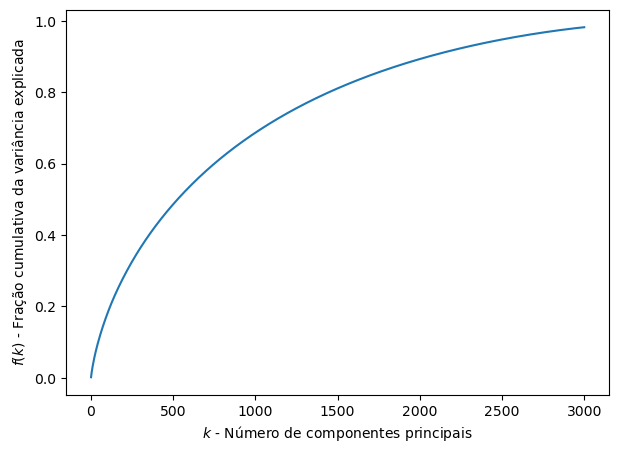

In [49]:
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, svd[0].n_components + 1)], np.cumsum(svd[0].explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada')

### Verificando Algorimo Espectral - Escolha do K

Text(0, 0.5, 'Autovalor')

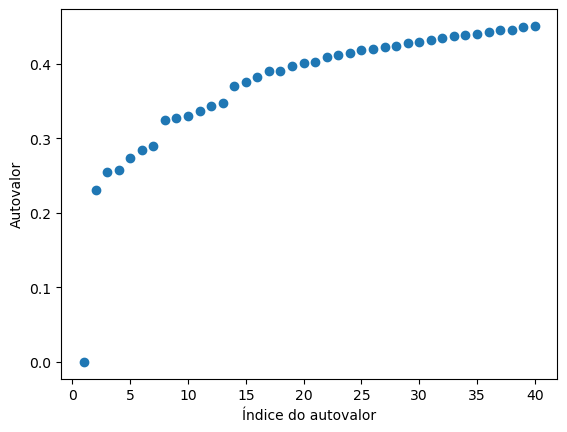

In [79]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from numpy import linalg as LA

# 1 Construindo a matriz de adjacências do grafo de vizinhos mais próximos.
G = kneighbors_graph(X, n_neighbors = 35, include_self = True)
A = 0.5 * (G + G.T)

# 2 Construindo a Laplaciana Normalizada
L = csgraph.laplacian(A, normed = True).todense()

# 3 Obtendo os autovalores da Laplaciana Normalizada
# Valores já estão ordenados em ordem crescente.
values, _ = LA.eigh(L)

# 4 Plotando os valores dos 'gaps' e escolhendo um k adequado.
plt.scatter([i for i in range(1, 41)], values[:40])
plt.xlabel('Índice do autovalor')
plt.ylabel('Autovalor')

### Agrupando

In [80]:
k_group = 6
m = SpectralClustering(n_clusters = k_group, affinity = 'nearest_neighbors', n_neighbors = 35)
m.fit(X)

SpectralClustering(affinity='nearest_neighbors', n_clusters=6, n_neighbors=35)

### Análise dos Grupos

#### Atribuindo os Grupos

In [81]:
filmes_espec_df['grupos'] = m.labels_

#### Matriz Generos X Grupos

In [82]:
generosXgrupos = filmes_espec_df.groupby(['genres_list', 'grupos']).size().unstack(fill_value=0)
generosXgrupos

grupos,0,1,2,3,4,5
genres_list,,,,,,
Action,1895,14,10,19,5,48
Biography,494,1,0,13,1,2
Crime,1982,30,25,7,18,13
Family,549,0,2,2,1,0
Horror,1510,11,8,2,2,1
Musical,302,1,5,1,3,0
Romance,2117,10,20,21,6,5
Sci-Fi,615,7,4,0,1,2
Sport,212,0,0,1,0,2


**Grupos ordenados em ordem decrescente em relação à quantidade de filmes no grupos**

In [83]:
generosXgrupos = generosXgrupos[generosXgrupos.sum().sort_values(ascending=False).index]
generosXgrupos

grupos,0,1,2,5,3,4
genres_list,,,,,,
Action,1895,14,10,48,19,5
Biography,494,1,0,2,13,1
Crime,1982,30,25,13,7,18
Family,549,0,2,0,2,1
Horror,1510,11,8,1,2,2
Musical,302,1,5,0,1,3
Romance,2117,10,20,5,21,6
Sci-Fi,615,7,4,2,0,1
Sport,212,0,0,2,1,0


**Mapa de Calor Geral - Figura 1**

<Axes: xlabel='grupos', ylabel='genres_list'>

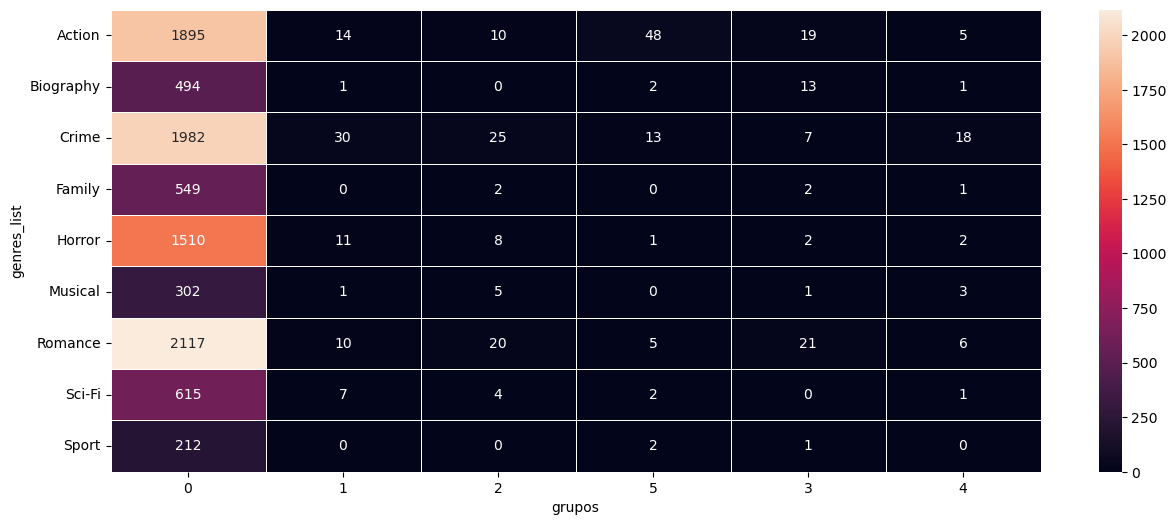

In [84]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generosXgrupos, annot=True, fmt="d", linewidths=0.5, ax=ax)

**Mapa de Calor Colunas Normalizadas - Figura 2**

In [85]:
# Normalizando os valores das colunas
generos_norm = generosXgrupos.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
generos_norm

grupos,0,1,2,5,3,4
genres_list,,,,,,
Action,0.883465,0.466667,0.40,1.000000,0.904762,0.277778
Biography,0.148031,0.033333,0.00,0.041667,0.619048,0.055556
Crime,0.929134,1.000000,1.00,0.270833,0.333333,1.000000
Family,0.176903,0.000000,0.08,0.000000,0.095238,0.055556
Horror,0.681365,0.366667,0.32,0.020833,0.095238,0.111111
Musical,0.047244,0.033333,0.20,0.000000,0.047619,0.166667
Romance,1.000000,0.333333,0.80,0.104167,1.000000,0.333333
Sci-Fi,0.211549,0.233333,0.16,0.041667,0.000000,0.055556
Sport,0.000000,0.000000,0.00,0.041667,0.047619,0.000000


<Axes: xlabel='grupos', ylabel='genres_list'>

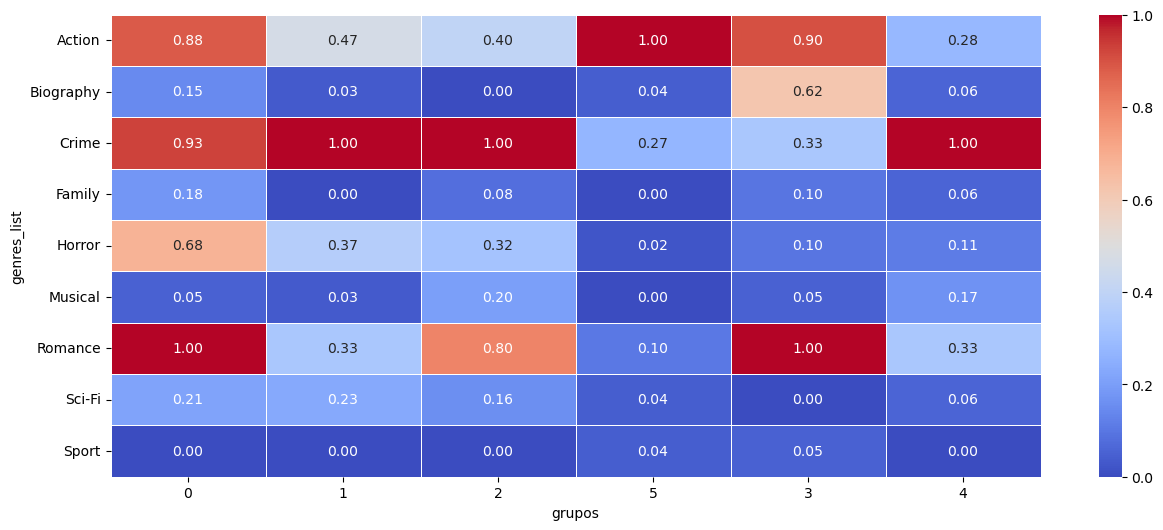

In [86]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generos_norm, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, ax=ax)

**Mapa de Calor Porcentagem de Generos nos Grupos - Figura 3**

In [87]:
generos_por = generosXgrupos.apply(lambda x: x / x.sum())
generos_por

grupos,0,1,2,5,3,4
genres_list,,,,,,
Action,0.195845,0.189189,0.135135,0.657534,0.287879,0.135135
Biography,0.051054,0.013514,0.000000,0.027397,0.196970,0.027027
Crime,0.204837,0.405405,0.337838,0.178082,0.106061,0.486486
Family,0.056738,0.000000,0.027027,0.000000,0.030303,0.027027
Horror,0.156056,0.148649,0.108108,0.013699,0.030303,0.054054
Musical,0.031211,0.013514,0.067568,0.000000,0.015152,0.081081
Romance,0.218789,0.135135,0.270270,0.068493,0.318182,0.162162
Sci-Fi,0.063559,0.094595,0.054054,0.027397,0.000000,0.027027
Sport,0.021910,0.000000,0.000000,0.027397,0.015152,0.000000


<Axes: xlabel='grupos', ylabel='genres_list'>

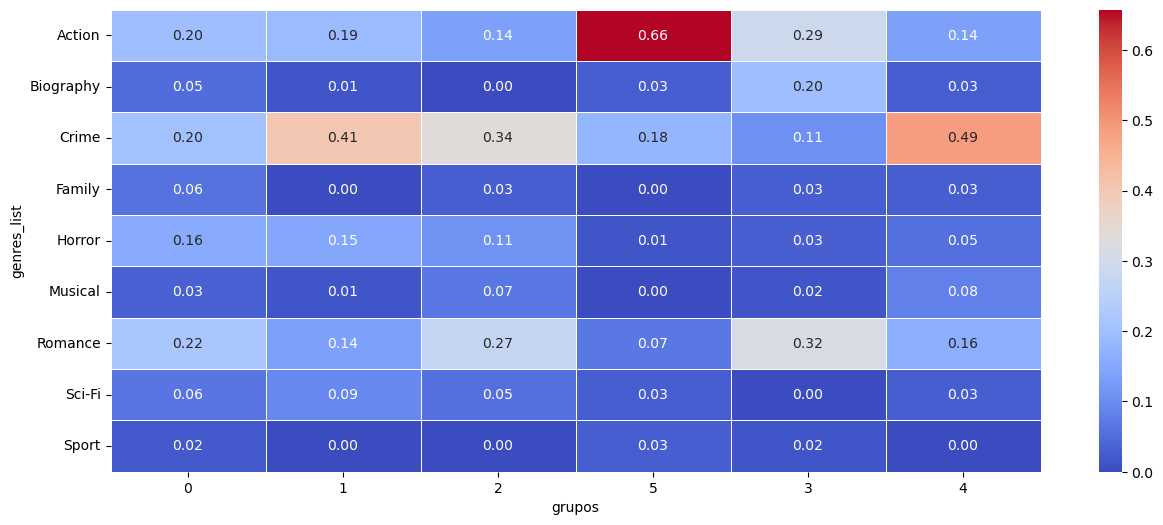

In [88]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generos_por, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, ax=ax)